In [7]:
import xml.etree.ElementTree as ET
import os
import dill
import pandas as pd
import numpy as np
from datetime import datetime
import operator
import re
import bokeh
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import base
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import FeatureUnion, Pipeline

os.chdir('/home/vagrant/projects/stackoverflow-post')
df = dill.load(open('data/df.pkd', 'r'))
# df_tag = dill.load(open('data/df_tag.pkd', 'r'))

In [4]:
tag_count = dict()
for tag in df.q_tag:
    li = tag.split('><')
    for j in li:
        j = j.replace('<', '')
        j = j.replace('>', '')
        if j not in tag_count:
            tag_count[j] = 1
        else:
            tag_count[j] += 1
sortedTags = sorted(tag_count.items(), key = operator.itemgetter(1), reverse = True)
selectedTags = {k:v for k,v in sortedTags if v>=len(df)*0.01} #use 1% as threshold to create matrix for tags
sortedTags

[('c#', 15092),
 ('.net', 10512),
 ('java', 7855),
 ('asp.net', 7212),
 ('c++', 5771),
 ('javascript', 5307),
 ('php', 4458),
 ('python', 4005),
 ('sql', 3857),
 ('sql-server', 3658),
 ('html', 2724),
 ('windows', 2554),
 ('jquery', 2319),
 ('mysql', 2279),
 ('c', 2207),
 ('database', 2131),
 ('visual-studio', 2081),
 ('asp.net-mvc', 1959),
 ('css', 1873),
 ('wpf', 1867),
 ('vb.net', 1799),
 ('xml', 1737),
 ('winforms', 1706),
 ('ruby', 1697),
 ('iphone', 1681),
 ('ruby-on-rails', 1660),
 ('performance', 1524),
 ('linux', 1517),
 ('visual-studio-2008', 1424),
 ('regex', 1325),
 ('svn', 1236),
 ('ajax', 1185),
 ('linq', 1177),
 ('multithreading', 1176),
 ('web-services', 1170),
 ('unit-testing', 1109),
 ('algorithm', 1108),
 ('security', 1098),
 ('sql-server-2005', 1083),
 ('oracle', 1034),
 ('user-interface', 1020),
 ('language-agnostic', 1007),
 ('string', 993),
 ('objective-c', 989),
 ('delphi', 985),
 ('perl', 957),
 ('oop', 953),
 ('flex', 947),
 ('winapi', 928),
 ('flash', 922),
 

In [12]:
# selectedTags #tags that have at least 1% coverage in df
pd.DataFrame([k for k,v in sortedTags])[0].to_csv('data/tag_category.csv')

In [15]:
class DictEncoder(base.BaseEstimator, base.TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        result = []
        for lst in X:
            arr = lst.split('><')
            d = dict()
            for i in arr:
                i = i.replace('<', '')
                i = i.replace('>', '')
                if i in selectedTags:
                    d[i] = 1
            result.append(d)
        return result
    
de = DictEncoder()
dv = DictVectorizer(sparse = False)
tag_dict = de.fit_transform(df.q_tag)
tag_mat = dv.fit_transform(tag_dict)

In [16]:
tag_pd = pd.DataFrame(tag_mat, columns = dv.get_feature_names())
df_tag = pd.concat([df, tag_pd], axis = 1)
df_tag = dill.dump(df_tag, open('data/df_tag.pkd', 'w'))

In [7]:
dill.dump([tag for (tag, count) in sortedTags[0:10]], open('data/top10tags.pkd', 'w'))

In [8]:
#draw boxplot grouped by tag
top10 = [n for (n,v) in sortedTags[0:10]]
def Cat(r, o):
    result = []
    for name in top10:
        d = dict()
        if r[name] == 1:
            d['Category'] = name
            d[o] = r['value']
            result.append(d)
    return result
def renderData_byOutcome(outcome):
    meltTop10 = pd.melt(df_tag, id_vars=top10, value_vars=outcome, var_name = outcome)
    pairs = meltTop10.apply(lambda row: Cat(row, outcome), axis = 1)
    plot_data = pd.DataFrame([e for li in pairs for e in li])
    plot_df = pd.DataFrame(plot_data)
    return plot_df
def rank_byTag(data, outcome):
    return data.groupby('Category')[outcome].mean().sort_values(ascending = False)
def boxplot_byTag(data, outcome):
    sortList = list(data.groupby('Category')[outcome].mean().sort_values(ascending = False).index)
    fig, ax = plt.subplots(figsize=(20,20))
    ax.set_xlabel('Top 10 Tags')
    ax.set_ylabel(outcome)
    ax.set_title('')
    data['Category'] = pd.Categorical(data['Category'], sortList)
    data = data.sort_values(by='Category', ascending = False)
    data.boxplot(column = outcome, by = 'Category', ax = ax)   
    plt.show()

In [9]:
plotData = renderData_byOutcome('fa_time')
rank_byTag(plotData, 'fa_time')

Category
.net          212830.716066
java          194630.823648
asp.net       194250.605056
sql-server    184722.852948
python        151174.067369
javascript    146716.899223
c#            145209.555426
php           108792.954735
c++           101422.547714
sql            73946.241155
Name: fa_time, dtype: float64

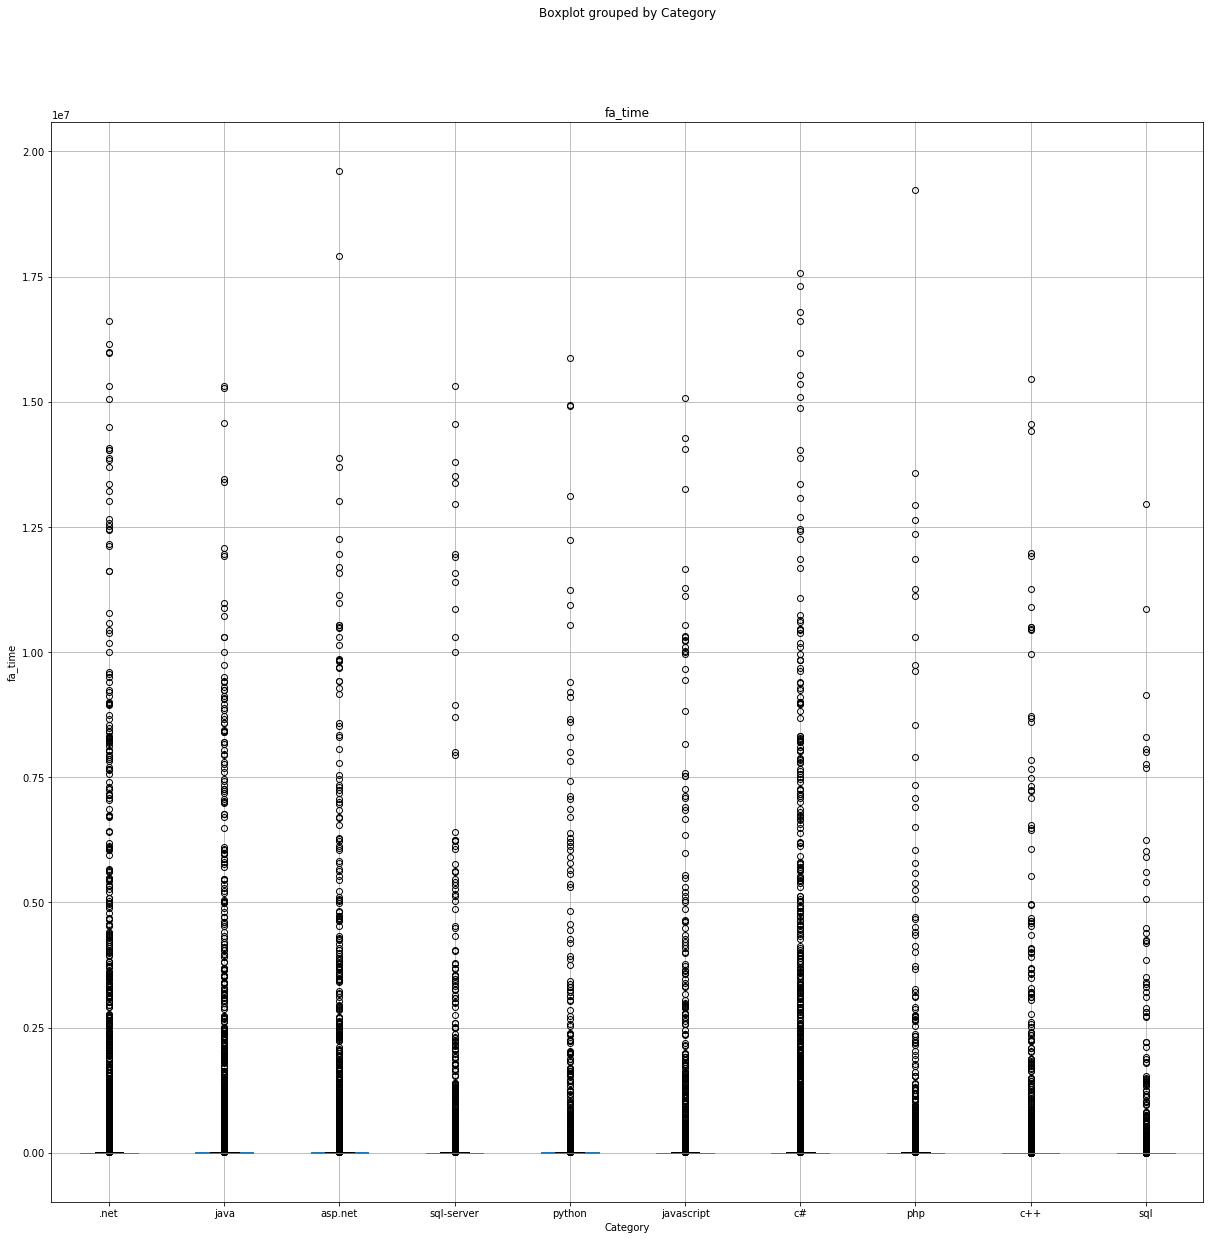

In [10]:
boxplot_byTag(plotData, 'fa_time')